In [1]:
# Import internal libraries
import glob

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(1, 3):
    for att in range(10, 255, 20):
        # Load and compute data
        postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{att}.csv", delimiter=',', dtype=np.int8)
        dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd_dac = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
        energy_tot = power_tot * dt
        bw = 2**16 * 48 * bpc / dt # bits per second
        energy_per_bit = energy_tot / 2**16 / 48 / bpc
        edp = energy_per_bit / bw

        # Load data into confmat
        confmat = np.zeros(shape=(2**bpc, 2**bpc))
        for i in range(65536):
            for j in range(48):
                if j in [19,29,38,43]:
                    continue
                confmat[j % (2**bpc)][postread[i][j]] += 1
        confmat = confmat.astype(int)
        print(confmat)

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = confmat.trace() / confmat.sum()
        
        # Compose dataframe
        data.append({"att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse})
data = pd.DataFrame(data)
data

[[1477722   29606]
 [     13 1376243]]
[[1480577   26751]
 [      9 1376247]]
[[1481926   25402]
 [     12 1376244]]
[[1483366   23962]
 [     10 1376246]]
[[1484641   22687]
 [     11 1376245]]
[[1485855   21473]
 [      7 1376249]]
[[769646     42    401  16343]
 [ 12631 697126   8147   2992]
 [  1869  13272 700198   5557]
 [     0      1     71 655288]]
[[771180     31     54  15167]
 [  8075 708275   1461   3085]
 [   333  10318 706989   3256]
 [     0      1     34 655325]]
[[771473     34     28  14897]
 [  6326 710511    970   3089]
 [   214  10157 707151   3374]
 [     0      2     27 655331]]
[[771710     38     29  14655]
 [  5416 711544    893   3043]
 [   176  10037 707635   3048]
 [     0      1     37 655322]]
[[772011     40     20  14361]
 [  4537 712457    898   3004]
 [   145  10040 706987   3724]
 [     0      1     25 655334]]
[[772209     58     21  14144]
 [  3925 713133    890   2948]
 [   152  11657 706204   2883]
 [     0      2     34 655324]]


,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,mae,rmse
0,10,1,0.2544674873352051,0.047376,3.832357e-09,3.100110e-16,1.236200e+07,0.989728,0.010272,0.010272,0.101349
1,30,1,0.610790491104126,0.034272,6.654363e-09,1.292045e-15,5.150257e+06,0.990720,0.009280,0.009280,0.096333
2,50,1,0.9400157928466797,0.031291,9.350491e-09,2.794142e-15,3.346463e+06,0.991187,0.008813,0.008813,0.093879
3,70,1,1.2381255626678467,0.030926,1.217216e-08,4.790834e-15,2.540718e+06,0.991687,0.008313,0.008313,0.091177
4,90,1,1.516352653503418,0.030614,1.475719e-08,7.113490e-15,2.074536e+06,0.992129,0.007871,0.007871,0.088721
5,110,1,1.7614233493804932,0.030086,1.684626e-08,9.432919e-15,1.785901e+06,0.992551,0.007449,0.007449,0.086308
6,10,2,0.825127124786377,0.031035,4.070286e-09,5.338198e-16,7.624832e+06,0.978733,0.011546,0.034428,0.268484
7,30,2,1.184664011001587,0.029602,5.573982e-09,1.049566e-15,5.310751e+06,0.985499,0.007853,0.026225,0.245342
8,50,2,1.452723741531372,0.028900,6.673065e-09,1.540839e-15,4.330800e+06,0.986434,0.007361,0.025054,0.241583
9,70,2,1.692478895187378,0.028487,7.663273e-09,2.061515e-15,3.717302e+06,0.987039,0.007044,0.024252,0.238744


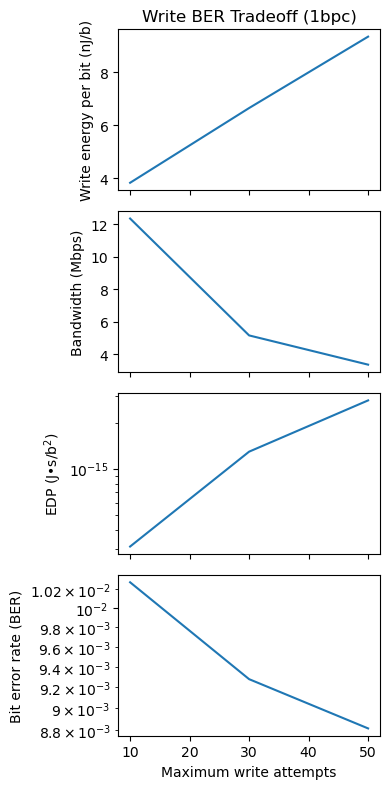

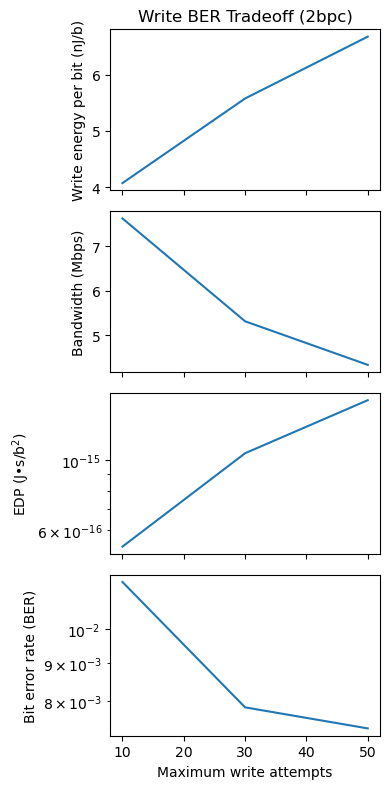

In [10]:
# Plot write BER tradeoff vs. attempts
for bpc, d in data.groupby("bpc"):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"])
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"])
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
    plt.show()

## Experiments part

In [4]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data/"
for fname in glob.glob(f"{datadir}/dt_*.csv"):
    # Extract info from filename
    _, _, bpc, lvl, expt, att = fname[:-4].split('_')[-6:]
    bpc, lvl, expt, att = int(bpc[0]), int(lvl[3:]), int(expt), int(att)

    # Load and compute data
    try:
        postread = np.loadtxt(fname.replace("dt", "postread"), delimiter=',', dtype=np.int8)
        dt = np.loadtxt(fname, delimiter=',')
        ivdd = np.loadtxt(fname.replace("dt", "vdd_power"), delimiter=',')
        ivdd_dac = np.loadtxt(fname.replace("dt", "vdd_dac_power"), delimiter=',')
        ivsa = np.loadtxt(fname.replace("dt", "vsa_power"), delimiter=',')
        ivddio = np.loadtxt(fname.replace("dt", "vddio_power"), delimiter=',')
        ivddio_dac = np.loadtxt(fname.replace("dt", "vddio_dac_power"), delimiter=',')
    except OSError:
        continue
    postread_cer = (postread != lvl).mean()
    power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
    energy_tot = power_tot * dt
    bw = 2**16 * 48 * bpc / dt # bits per second
    energy_per_bit = energy_tot / 2**16 / 48 / bpc
    edp = energy_per_bit / bw

    # Confusion vector
    confvec = np.unique(postread, return_counts=True)
    print(confvec)

    # Compose dataframe
    data.append({"att": att, "bpc": bpc, "lvl": lvl, "expt": expt, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": postread_cer})
data = pd.DataFrame(data)
data

ValueError: not enough values to unpack (expected 6, got 3)